In [39]:
%%capture

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchtext.vocab import build_vocab_from_iterator
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score_fn
import matplotlib.pyplot as plt
import random
import re
from collections import Counter
from tqdm import tqdm
from tqdm.notebook import tqdm
import gdown
from functools import partial

import pickle
import numpy as np
import pandas as pd
import time
import os
import sys
import spacy
import ast

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [40]:

if torch.backends.mps.is_available():
    DEVICE = 'mps'  # Apple GPU 사용
elif torch.cuda.is_available():
    DEVICE = 'cuda'  # NVIDIA GPU 사용
else:
    DEVICE = 'cpu'   # CPU fallback

print(DEVICE)

cuda


In [41]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [42]:
# data 다운
train_path = 'Cooking_Dataset/train.csv'
dev_path = 'Cooking_Dataset/dev.csv'
test_path = 'Cooking_Dataset/test.csv'


if not os.path.exists('Cooking_Dataset'):
    os.makedirs('Cooking_Dataset')
    print("Downloading Dataset")
    gdown.download("https://drive.google.com/uc?id=1uZdYjvllt0dSdKKtrCgKHUk-APKdmeNU", train_path, quiet=False)
    gdown.download("https://drive.google.com/uc?id=1SAMbkdtjGBYgojqobiwe7ZmnEq7SiGsF", dev_path, quiet=False)
    gdown.download("https://drive.google.com/uc?id=1v6Rr2et_4WA5mRwwlRxtLhn38pbmr9Yr", test_path, quiet=False)


train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

# 데이터 확인
print(f"Train data size: {len(train_df)}")
print(f"Dev data size: {len(dev_df)}")
print(f"Test data size: {len(test_df)}")
print("\nTrain data sample:")
print(train_df.head())
#No-Bake Nut Cookies
# ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]
# ["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]

Train data size: 162899
Dev data size: 1065
Test data size: 1081

Train data sample:
                      Title  \
0       No-Bake Nut Cookies   
1               Creamy Corn   
2      Reeses Cups(Candy)     
3  Cheeseburger Potato Soup   
4       Rhubarb Coffee Cake   

                                         Ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
2  ["1 c. peanut butter", "3/4 c. graham cracker ...   
3  ["6 baking potatoes", "1 lb. of extra lean gro...   
4  ["1 1/2 c. sugar", "1/2 c. butter", "1 egg", "...   

                                              Recipe  
0  ["In a heavy 2-quart saucepan, mix brown sugar...  
1  ["In a slow cooker, combine all ingredients. C...  
2  ["Combine first four ingredients and press in ...  
3  ["Wash potatoes; prick several times with a fo...  
4  ["Cream sugar and butter.", "Add egg and beat ...  


In [43]:
spacy_en = spacy.load('en_core_web_sm')

def tokenizer_ingredient_baseline(text):
    """
    Baseline 전처리: 소문자화 + lemmatization + 간단한 필터링
    - stopword 제거 있음
    - 숫자, 구두점 제거 있음
    - 불필요한 복잡 전처리 없음
    """
    import ast
    text_list = ast.literal_eval(text)
    tokens = []

    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        for item in text_list:
            doc = spacy_en(item.lower())
            for token in doc:
                if token.is_punct or token.like_num or token.is_stop:
                    continue
                tokens.append(token.lemma_.strip())  # 기본 lemmatization만 유지
    return tokens



def tokenizer_recipe_baseline(text):
    """
    Recipe 전처리: 소문자화 + lemmatization만 수행 (구두점, stopword, 숫자는 유지)
    - 조리 순서, 동사 등 자연스러운 문장 흐름을 보존해야 하므로 간단한 전처리만 적용
    """
    tokens = []
    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        doc = spacy_en(text.lower())
        for token in doc:
            # 너무 공격적인 필터링은 하지 않음
            if token.is_space:
                continue
            tokens.append(token.lemma_.strip())
    return tokens





def tokenizer_ingredient_extension(text, remove_stopwords=True, lemmatize=True):
    text_list = ast.literal_eval(text)  # 문자열 → 리스트로 변환
    unit_keywords = {
        'c', 'cup', 'cups', 'tbsp', 'tablespoon', 'tsp', 'teaspoon',
        'oz', 'ounce', 'lb', 'pound', 'g', 'kg', 'mg',
        'pt', 'qt', 'gal', 'ml', 'l', 'extra', 'carton','container',
        'package', 'pkg', 'envelope', 'box', 'bag', 'jar', 'can', 'cans', 'bottle',
        'dash', 'pinch', 'slice', 'slices', 'head', 'inch', 'inches',
        'stick', 'sticks', 'small', 'medium', 'large', 'size', 'graham'
    }

    tokens = []

    with spacy_en.select_pipes(disable=["parser", "ner"]):
        for item in text_list:
            doc = spacy_en(item.lower())
            for token in doc:
                if token.is_punct or token.is_space:
                    continue
                if token.like_num:
                    continue
                if token.text.strip(".") in unit_keywords:
                    continue
                if remove_stopwords and token.is_stop:
                    continue
                if token.pos_ not in {"NOUN", "ADJ"}:
                     continue

                tokens.append(token.lemma_.strip() if lemmatize else token.text.strip())
    return tokens

def tokenizer_recipe_extension(text):  # 디폴트: lemmatize 안 함
    text_list = ast.literal_eval(text)
    tokens = []

    # tagger는 유지해서 lemma 써도 warning 없음
    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        for item in text_list:
            doc = spacy_en(item.lower())  # 소문자화
            for token in doc:
                if token.is_punct or token.is_space:
                    continue  # 마침표, 쉼표 제거
                if token.like_num:  # 숫자 유지
                    tokens.append(token.text.strip())
                    continue
                
                tokens.append(token.text.strip())
                
    return tokens




In [44]:
ing = train_df.iloc[1,2]
print(ing)
print(tokenizer_recipe_extension(ing))

["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated through and cheese is melted. Stir well before serving. Yields 6 servings."]
['in', 'a', 'slow', 'cooker', 'combine', 'all', 'ingredients', 'cover', 'and', 'cook', 'on', 'low', 'for', '4', 'hours', 'or', 'until', 'heated', 'through', 'and', 'cheese', 'is', 'melted', 'stir', 'well', 'before', 'serving', 'yields', '6', 'servings']


/home/psarda/repos/jkim0094-CookingRecipeGenerato/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [45]:
def build_vocab(token_lists, min_freq=2):
    # vocab 생성: 자주 등장하는 단어만 포함 + 특수 토큰 정의
    vocab = build_vocab_from_iterator(
        token_lists,  # 토큰 리스트들을 직접 반복
        min_freq=min_freq,  # 최소 등장 빈도
        specials=['<pad>', '<sos>', '<eos>', '<unk>']  # 특수 토큰 추가
    )
    vocab.set_default_index(vocab['<unk>'])  # 없는 단어는 <unk>로 처리
    return vocab

In [46]:
import os
import pickle
import requests
from tqdm import tqdm

def load_or_tokenize_data(model_type, train_df):
    if "extension" in model_type:
        tokenizer_ingredient = tokenizer_ingredient_extension
        tokenizer_recipe = tokenizer_recipe_extension
        ingredient_cache_path = "tokens/ingredient_tokens_ext.pkl"
        recipe_cache_path = "tokens/recipe_tokens_ext.pkl"
        ingredient_cache_download = "https://drive.google.com/uc?id=1uls7_WdUdXYq3yyDAQb_YI89qAThBTo0"
        recipe_cache_download = "https://drive.google.com/uc?id=1tf_r_QaVZBUl66rj4ldFXMGZ-ft98_IS"
    else:
        tokenizer_ingredient = tokenizer_ingredient_baseline
        tokenizer_recipe = tokenizer_recipe_baseline
        ingredient_cache_path = "tokens/ingredient_tokens.pkl"
        recipe_cache_path = "tokens/recipe_tokens.pkl"
        ingredient_cache_download = "https://drive.google.com/uc?id=1Wxvq-qy4ifbzPKmcm_VuNRRXrEOSqisJ"
        recipe_cache_download = "https://drive.google.com/uc?id=1IyBlDfL9sE8_Ip3muDyciCK9Hiv_VZF8"

    if not os.path.exists('tokens'):
        os.makedirs('tokens')

    # 다운로드 시도 (ingredient)
    if not os.path.exists(ingredient_cache_path):
        print(f"⬇️  Downloading: {ingredient_cache_path}")
        try:
            r = requests.get(ingredient_cache_download, allow_redirects=True)
            if r.status_code == 200:
                with open(ingredient_cache_path, 'wb') as f:
                    f.write(r.content)
                print(f"✅ Downloaded: {ingredient_cache_path}")
            else:
                print("❌ Ingredient download failed, will tokenize.")
        except Exception as e:
            print(f"❌ Ingredient download error: {e}")

    # 다운로드 시도 (recipe)
    if not os.path.exists(recipe_cache_path):
        print(f"⬇️  Downloading: {recipe_cache_path}")
        try:
            r = requests.get(recipe_cache_download, allow_redirects=True)
            if r.status_code == 200:
                with open(recipe_cache_path, 'wb') as f:
                    f.write(r.content)
                print(f"✅ Downloaded: {recipe_cache_path}")
            else:
                print("❌ Recipe download failed, will tokenize.")
        except Exception as e:
            print(f"❌ Recipe download error: {e}")

    # --- Ingredient Token 처리 ---
    if os.path.exists(ingredient_cache_path):
        with open(ingredient_cache_path, "rb") as f:
            ingredient_token_lists = pickle.load(f)
        print("✅ Loaded ingredient token cache.")
    else:
        print("⚠️ No ingredient cache → Tokenizing...")
        ingredient_token_lists = [
            tokenizer_ingredient(text) for text in tqdm(train_df['Ingredients'], desc="Tokenizing ingredients")
        ]
        with open(ingredient_cache_path, "wb") as f:
            pickle.dump(ingredient_token_lists, f)

    # --- Recipe Token 처리 ---
    if os.path.exists(recipe_cache_path):
        with open(recipe_cache_path, "rb") as f:
            recipe_token_lists = pickle.load(f)
        print("✅ Loaded recipe token cache.")
    else:
        print("⚠️ No recipe cache → Tokenizing...")
        recipe_token_lists = [
            tokenizer_recipe(text) for text in tqdm(train_df['Recipe'], desc="Tokenizing recipes")
        ]
        with open(recipe_cache_path, "wb") as f:
            pickle.dump(recipe_token_lists, f)

    ingredient_vocab = build_vocab(ingredient_token_lists, min_freq=1)
    recipe_vocab = build_vocab(recipe_token_lists, min_freq=2)

    return ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe


In [47]:
class CustomDataset(Dataset):
    def __init__(self, df, ingredient_vocab, recipe_vocab,
                 tokenizer_ingredient, tokenizer_recipe):
        self.df = df
        self.ingredient_vocab = ingredient_vocab
        self.recipe_vocab = recipe_vocab
        self.tokenizer_ingredient = tokenizer_ingredient
        self.tokenizer_recipe = tokenizer_recipe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        ingredient_tokens = self.tokenizer_ingredient(self.df.iloc[idx]["Ingredients"])
        recipe_tokens = self.tokenizer_recipe(self.df.iloc[idx]["Recipe"])

        ingredient_ids = [self.ingredient_vocab[token] for token in ingredient_tokens]
        recipe_ids = [self.recipe_vocab['<sos>']] + \
                     [self.recipe_vocab[token] for token in recipe_tokens] + \
                     [self.recipe_vocab['<eos>']]

        return torch.tensor(ingredient_ids), torch.tensor(recipe_ids)


In [48]:
def collate_fn(batch, ingredient_vocab, recipe_vocab, device):
    ingredients, recipes = zip(*batch)
    ingredients_padded = pad_sequence(ingredients, batch_first=True, padding_value=ingredient_vocab['<pad>'])
    recipes_padded = pad_sequence(recipes, batch_first=True, padding_value=recipe_vocab['<pad>'])
    return ingredients_padded.to(device), recipes_padded.to(device)

In [49]:
class Encoder_GRU(nn.Module):
    def __init__(self, ingredient_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio,
                 embedding_weights=None, freeze=False):
        super().__init__()
        # 임베딩
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze)
        else:
            self.embedding = nn.Embedding(ingredient_vocab_size, embedding_dim)
        

        # GRU 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          dropout=dropout_ratio if n_layers>1 else 0,
                          batch_first=True)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src):
        # src : [batch_size, src_len]
        src = src.long() 
        # 임베딩
        embedded = self.dropout(self.embedding(src))
        # embedded : [batch_size, src_len, hidden_dim]

        # gru 통과
        outputs, hidden = self.gru(embedded) # h0를 따로 주지 않으면, 디폴트로 h0가 0로 초기화되서 들어감
        # outputs: [batch_size, src_len, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        return outputs,hidden

class Encoder_GRU_extension(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio,
                 embedding_weights=None, freeze=False):
        super().__init__()
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout_ratio)

        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers,
                          dropout=dropout_ratio if n_layers > 1 else 0,
                          batch_first=True)

        self.skip_proj = nn.Linear(embedding_dim, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self._init_weights()  # ✅ 초기화 적용

    def _init_weights(self):
        # embedding 초기화 (from_pretrained 아닌 경우만)
        if not hasattr(self.embedding, 'weight') or self.embedding.weight.requires_grad:
            nn.init.kaiming_normal_(self.embedding.weight, mode='fan_in', nonlinearity='leaky_relu')

        # GRU 내부 weight 초기화
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='leaky_relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0)

        # skip connection projection 초기화
        nn.init.kaiming_normal_(self.skip_proj.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(self.skip_proj.bias, 0)

    def forward(self, src):
        src = src.long()
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.gru(embedded)
        skip = self.skip_proj(embedded)
        outputs = self.leaky_relu(outputs + skip)
        outputs = self.layer_norm(outputs)
        return outputs, hidden



class Decoder_GRU(nn.Module):
    def __init__(self, recipe_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio):
        super().__init__()

        self.recipe_vocab_size = recipe_vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        # 임베딩
        self.embedding = nn.Embedding(recipe_vocab_size, embedding_dim)

        # GRU 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          dropout=dropout_ratio if n_layers>1 else 0,
                          batch_first=True)

        # fc 레이어
        self.fc_out = nn.Linear(hidden_dim, recipe_vocab_size)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, input, hidden):
        input = input.long()
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, 단어의 개수=1]

        # 임베딩
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, 단어의 개수=1, hidden_dim]

        # GRU 통과
        outputs, hidden = self.gru(embedded,hidden)
        # outputs: [batch_size, 단어의 개수=1, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        # fc 통과
        prediction = self.fc_out(outputs.squeeze(1))
        # prediction: [batch_size, vocab_size]

        return prediction, hidden

# Define a decoder with attention mechanism using PyTorch's nn.Module
class AttnDecoderRNN(nn.Module):
    def __init__(self, recipe_vocab_size,embedding_dim, hidden_size, n_layers, dropout_ratio):
        # Initialize the base nn.Module class
        super(AttnDecoderRNN, self).__init__()

        # Save parameters
        self.recipe_vocab_size = recipe_vocab_size              # Size of the output vocabulary
        self.embedding_dim = embedding_dim                  # Dropout probability
        self.hidden_size = hidden_size              # Size of the hidden state in GRU
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio
                  

        # Define layers
        self.embedding = nn.Embedding(self.recipe_vocab_size, self.hidden_size)  # Converts word indices to dense vectors
        self.dropout = nn.Dropout(self.dropout_ratio)                          # Applies dropout for regularization
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers, dropout=self.dropout_ratio if self.n_layers>1 else 0, batch_first=True)
             # GRU to process the embedded inputs
        self.out = nn.Linear(self.hidden_size * 2, self.recipe_vocab_size)       # Linear layer for generating final output

    def forward(self, input, hidden, encoder_outputs):
        input = input.long() 
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, 단어의 개수=1]

        # 임베딩
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, 단어의 개수=1, hidden_dim]

        # Pass through GRU
        output, hidden = self.gru(embedded, hidden)  # output: [batch, 1, hidden_size]

        # Compute attention weights using dot-product attention:
        # hidden[-1]: [batch, hidden_size]
        # encoder_outputs: [batch, src_len, hidden_size]
    
        attn_weights = F.softmax(
            torch.bmm(output, encoder_outputs.transpose(1, 2)), # [batch, 1, hidden_size] x [batch, hidden_size, src_len]
            dim=-1
        )  # [batch, 1, src_len]

        # Apply attention weights to encoder outputs to get context vector
        # attn_weights: (1, 1, max_length)
        # encoder_outputs.unsqueeze(0): (1, max_length, hidden_size)
        attn_output = torch.bmm(attn_weights, encoder_outputs)  # [batch, 1, hidden_size]

        # Concatenate attention output and decoder hidden state
        concat_output = torch.cat((output, attn_output), dim=2)  # [batch, 1, hidden*2]

        # Pass through linear layer and softmax to get output word probabilities
        output = F.log_softmax(self.out(concat_output).squeeze(1), dim=1)  # [batch, vocab_size]

        # Return output word distribution, updated hidden state, and attention weights
        return output, hidden, attn_weights.squeeze(1)

class AttnDecoderRNN_extension(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, dropout_ratio):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.gru = nn.GRU(embedding_dim, hidden_size, n_layers,
                          dropout=dropout_ratio if n_layers > 1 else 0,
                          batch_first=True)
        self.out = nn.Linear(hidden_size * 2, vocab_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.layer_norm = nn.LayerNorm(hidden_size)

        self._init_weights()  # ✅ He 초기화 호출

    def _init_weights(self):
        # Embedding
        nn.init.kaiming_normal_(self.embedding.weight, mode='fan_in', nonlinearity='leaky_relu')

        # GRU weights & biases
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='leaky_relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0)

        # Linear layer
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(self.out.bias, 0)

    def forward(self, input, hidden, encoder_outputs):
        input = input.long().unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        output = self.leaky_relu(output)
        output = self.layer_norm(output)

        attn_weights = F.softmax(torch.bmm(output, encoder_outputs.transpose(1, 2)), dim=-1)
        context = torch.bmm(attn_weights, encoder_outputs)
        concat_output = torch.cat((output, context), dim=2)
        output = F.log_softmax(self.out(concat_output).squeeze(1), dim=1)
        return output, hidden, attn_weights.squeeze(1)




class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, use_attention):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.use_attention = use_attention

    def forward(self, src, target=None, teacher_forcing_ratio=0.5, max_len=50):
        # 인코더
        encoder_outputs, hidden = self.encoder(src)
        batch_size = src.size(0)
        vocab_size = self.decoder.recipe_vocab_size

        # 추론 모드
        if target is None:
            outputs = []
            input_token = torch.tensor([recipe_vocab['<sos>']] * batch_size).to(self.device).long()

            for _ in range(max_len):
                if self.use_attention:
                    output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
                else:
                    output, hidden = self.decoder(input_token, hidden)
                top1 = output.argmax(1)
                outputs.append(top1.unsqueeze(1))
                input_token = top1

            return torch.cat(outputs, dim=1)  # [batch_size, max_len]

        # 학습 모드
        target = target.long()
        target_len = target.shape[1]
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
        input_token = target[:, 0].long()  # <sos>

        for t in range(1, target_len):
            if self.use_attention:
                output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
            else:
                output, hidden = self.decoder(input_token, hidden)
            outputs[:, t, :] = output
            top1 = output.argmax(1)
            teacher_force = random.random() < teacher_forcing_ratio
            input_token = target[:, t].long() if teacher_force else top1

        return outputs

import torch.nn.functional as F
    



    



In [50]:
def build_glove_embedding_matrix(glove_path, vocab, glove_dim=100):
    print("🔎 Loading GloVe vectors...")
    glove_embeddings = {}

    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = torch.tensor(list(map(float, values[1:])))
            glove_embeddings[word] = vector

    # Initialize matrix with random vectors
    embedding_matrix = torch.randn(len(vocab), glove_dim)

    for word, idx in vocab.get_stoi().items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]

    print("✅ GloVe embedding matrix created.")
    return embedding_matrix


In [51]:
def loss_epoch(model, dataloader, criterion, optimizer=None, teacher_forcing_ratio=0.5, max_len=50):
    rloss = 0
    batch_losses = []

    #for i, (src_batch, trg_batch) in enumerate(tqdm(dataloader, desc="Training batches",leave =False)):
    for i, (src_batch, trg_batch) in enumerate(dataloader):
        src_batch = src_batch.to(DEVICE)
        trg_batch = trg_batch.to(DEVICE)

        output = model(src_batch, trg_batch, teacher_forcing_ratio=teacher_forcing_ratio, max_len=max_len)
        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg = trg_batch[:, 1:].reshape(-1)

        loss = criterion(output, trg)

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

        batch_loss = loss.item() * src_batch.size(0)
        batch_losses.append(batch_loss)
        rloss += batch_loss

        tqdm.write(f"[Batch {i}/{len(dataloader)}] Train Loss: {loss.item():.4f}")

    avg_loss = rloss / len(dataloader.dataset)
    return avg_loss, batch_losses



def Train(model, train_loader, val_loader, criterion, optimizer,
          EPOCHS, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path, TEACHER_FORCING_RATIO, MAX_LEN, **kwargs
          ):
    """
    이어서 학습할 수 있게 start_epoch와 best_val_loss를 인자로 받음
    """
    lr_step = kwargs.get("LR_STEP")
    lr_gamma = kwargs.get("LR_GAMMA")

    if isinstance(lr_step, int) and isinstance(lr_gamma, float):
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)
    else:
        scheduler = None

    
    loss_history = {"train_epoch": [], "train_iter": [], "val_epoch": []}
    best_val_loss = float('inf')
    train_start_time = time.time()
    
    #for ep in tqdm(range(EPOCHS), desc="Epochs",file=sys.stdout):
    for ep in range(EPOCHS):
        print(f"Epoch {ep+1}/{EPOCHS}")

        ep_start_time = time.time()

        # Training
        model.train()
        train_epoch_loss, train_batch_loss= loss_epoch(
            model, train_loader, criterion, optimizer, 
            teacher_forcing_ratio=TEACHER_FORCING_RATIO,
            max_len=MAX_LEN
        )
        loss_history["train_epoch"].append(train_epoch_loss)
        loss_history["train_iter"].append(train_batch_loss)
        

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, _ = loss_epoch(
                model, val_loader, criterion, optimizer=None,
                teacher_forcing_ratio=0.0,
                max_len=MAX_LEN
            )
            loss_history["val_epoch"].append(val_loss)

        ep_elapsed_time = time.time() - ep_start_time

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # 디렉토리 없으면 생성
            os.makedirs("results", exist_ok=True)
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": ep,
                "val_loss": val_loss,
                "train_loss": train_epoch_loss,  # train_loss 저장
            }, save_model_path)
            print("Best model saved!")

        if scheduler is not None:
            scheduler.step()

        print(f"Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {ep_elapsed_time:.2f}s")
    train_elapsed_time = time.time() - train_start_time
    # Save training history
    total_iterations = sum(len(batch_list) for batch_list in loss_history["train_iter"])
    torch.save({
        "loss_history": loss_history,
        "EPOCHS": EPOCHS,
        "BATCH_SIZE": BATCH_SIZE,   
        "TRAIN_RATIO": TRAIN_RATIO,
        "train_elapsed_time": train_elapsed_time,
        "total_iterations": total_iterations,
        "LR_STEP": kwargs["LR_STEP"] if "LR_STEP" in kwargs else None,
        "LR_GAMMA": kwargs["LR_GAMMA"] if "LR_GAMMA" in kwargs else None
    }, save_history_path)
    print(f"Total number of iteration : {total_iterations}")
    print(f"Training Completed! Total Time: {train_elapsed_time:.2f}s")
    return loss_history



def Test(model, test_loader, criterion, recipe_vocab, MAX_LEN):
    model.eval()

    with torch.no_grad():
        test_loss, _ = loss_epoch(model, test_loader, criterion, optimizer=None, teacher_forcing_ratio=0.0, max_len=MAX_LEN)

    # 평가 지표 계산
    bleu_score, meteor_avg, bertscore_f1 = compute_metrics(model, test_loader, recipe_vocab)

    print(f"Test Loss      : {test_loss:.4f}")
    print(f"BLEU-4 Score   : {bleu_score:.4f}")
    print(f"METEOR Score   : {meteor_avg:.4f}")
    print(f"BERTScore (F1) : {bertscore_f1:.4f}")

    return test_loss, bleu_score, meteor_avg, bertscore_f1



def compute_metrics(model, dataloader, recipe_vocab, max_len=50):
    """
    테스트셋 전체에서 BLEU, METEOR, BERTScore 계산

    Returns:
        bleu_score (float), meteor_avg (float), bertscore_f1 (float)
    """
    model.eval()
    smoothie = SmoothingFunction().method4

    ref_list = []
    hyp_list = []

    with torch.no_grad():
        for src_batch, trg_batch in tqdm(dataloader, desc="Evaluating Metrics"):
            src_batch = src_batch.to(DEVICE)
            trg_batch = trg_batch.to(DEVICE)

            generated = model(src_batch, target=None, teacher_forcing_ratio=0.0, max_len=max_len)

            for i in range(src_batch.size(0)):
                pred_tokens = generated[i].tolist()
                trg_tokens = trg_batch[i].tolist()

                # <eos> 기준으로 자르기
                if recipe_vocab['<eos>'] in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(recipe_vocab['<eos>'])]
                if recipe_vocab['<eos>'] in trg_tokens:
                    trg_tokens = trg_tokens[:trg_tokens.index(recipe_vocab['<eos>'])]

                pred_words = [recipe_vocab.get_itos()[idx] for idx in pred_tokens]
                trg_words = [recipe_vocab.get_itos()[idx] for idx in trg_tokens]

                ref_list.append(trg_words)
                hyp_list.append(pred_words)

    # BLEU-4
    bleu_score = corpus_bleu([[ref] for ref in ref_list], hyp_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) 

    # METEOR
    meteor_scores = [meteor_score([ref], hyp) for ref, hyp in zip(ref_list, hyp_list)]
    meteor_avg = sum(meteor_scores) / len(meteor_scores)

    # BERTScore
    refs = [" ".join(ref) for ref in ref_list]
    hyps = [" ".join(hyp) for hyp in hyp_list]
    _, _, f1 = bert_score_fn(hyps, refs, lang='en', verbose=False)
    bertscore_f1 = f1.mean().item()

    return bleu_score, meteor_avg, bertscore_f1


def plot_loss_epoch(name, loss_history):
    plt.figure(figsize=(6, 3))

    train_loss = loss_history["train_epoch"]
    val_loss = loss_history["val_epoch"]

    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss", color="blue")
    plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss", color="red")

    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.title(f"Loss per Epoch: {name}", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_iter(**models_histories):
    plt.figure(figsize=(10, 6))
    for model_name, history in models_histories.items():
        train_iter_losses = history.get("train_iter", [])
        if train_iter_losses:
            flat_iter_losses = [loss for epoch_losses in train_iter_losses for loss in epoch_losses]
            plt.plot(flat_iter_losses, label=model_name)
        else:
            print(f"[경고] {model_name}에 train_iter 데이터가 없습니다.")

    plt.title("Training Iteration Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [52]:
def get_encoder_decoder(model_type, config, input_dim, output_dim, embedding_weights=None, freeze_embedding=False):
    use_attention = config["USE_ATTENTION"]

    # extension이면 Mild 버전 인코더/디코더 사용
    is_extension = model_type.startswith("extension")

    if is_extension:
        encoder = Encoder_GRU_Extension(
            vocab_size=input_dim,
            embedding_dim=config["EMBED_DIM"],
            hidden_dim=config["HIDDEN_DIM"],
            n_layers=config["N_LAYERS"],
            dropout_ratio=config["DROPOUT"],
            embedding_weights=embedding_weights,
            freeze=freeze_embedding
        )
        decoder = AttnDecoderRNN_Extension(
            vocab_size=output_dim,
            embedding_dim=config["EMBED_DIM"],
            hidden_size=config["HIDDEN_DIM"],
            n_layers=config["N_LAYERS"],
            dropout_ratio=config["DROPOUT"]
        )
    else:
        encoder = Encoder_GRU(
            ingredient_vocab_size=input_dim,
            embedding_dim=config["EMBED_DIM"],
            hidden_dim=config["HIDDEN_DIM"],
            n_layers=config["N_LAYERS"],
            dropout_ratio=config["DROPOUT"],
            embedding_weights=embedding_weights,
            freeze=freeze_embedding
        )
        if use_attention:
            decoder = AttnDecoderRNN(
                recipe_vocab_size=output_dim,
                embedding_dim=config["EMBED_DIM"],
                hidden_size=config["HIDDEN_DIM"],
                n_layers=config["N_LAYERS"],
                dropout_ratio=config["DROPOUT"]
            )
        else:
            decoder = Decoder_GRU(
                recipe_vocab_size=output_dim,
                embedding_dim=config["EMBED_DIM"],
                hidden_dim=config["HIDDEN_DIM"],
                n_layers=config["N_LAYERS"],
                dropout_ratio=config["DROPOUT"]
            )

    return encoder, decoder

def main(model_type: str, config: dict,
         train_df, dev_df, test_df,
         glove_path: str = "./glove.6B.100d.txt"):

    # 1. Tokenize & Vocab
    ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe = load_or_tokenize_data(model_type, train_df)

    # 2. GloVe embedding 적용 (config에 "embedding_weights" 키가 있는 경우)
    embedding_weights = None
    freeze_embedding = False
    if config.get("use_glove", False):
        ingredient_embedding_matrix = build_glove_embedding_matrix(glove_path, ingredient_vocab, glove_dim=config["EMBED_DIM"])
        embedding_weights = ingredient_embedding_matrix
    else:
        embedding_weights = None

    # 3. Dataset & DataLoader
    BATCH_SIZE = config.get("BATCH_SIZE", 64)
    train_dataset = CustomDataset(train_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)
    dev_dataset = CustomDataset(dev_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)
    test_dataset = CustomDataset(test_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)

    collate = partial(collate_fn, ingredient_vocab=ingredient_vocab, recipe_vocab=recipe_vocab, device=DEVICE)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate)
    dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False, collate_fn=collate)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate)

    # 4. Model 구성
    INPUT_DIM = len(ingredient_vocab)
    OUTPUT_DIM = len(recipe_vocab)
    criterion = nn.CrossEntropyLoss(ignore_index=recipe_vocab['<pad>'])

    encoder, decoder = get_encoder_decoder(
    model_type=model_type,
    config=config,
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    embedding_weights=embedding_weights,
    freeze_embedding=config.get("freeze_embedding", False)
)


    model = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)

    # 5. 학습 또는 로드
    save_model_path = f"results/{model_type}.pt"
    save_history_path = f"results/{model_type}_history.pt"

    if config["new_model_train"]:
        print(f"Training model: {model_type}")
        optimizer = optim.Adam(model.parameters(), lr=config["LR"])
        loss_history = Train(
            model=model,
            train_loader=train_loader,
            val_loader=dev_loader,
            criterion=criterion,
            optimizer=optimizer,
            EPOCHS=config["EPOCHS"],
            BATCH_SIZE=BATCH_SIZE,
            TRAIN_RATIO=1.0,
            save_model_path=save_model_path,
            save_history_path=save_history_path,
            TEACHER_FORCING_RATIO=config["TEACHER_FORCING_RATIO"],
            MAX_LEN=config["MAX_LEN"],
            LR_STEP=config.get("LR_STEP"),
            LR_GAMMA=config.get("LR_GAMMA")
        )
        return model, encoder, decoder, loss_history, save_model_path, save_history_path, test_loader, recipe_vocab
    else:
        return model, encoder, decoder, None, save_model_path, save_history_path, test_loader, recipe_vocab


In [53]:
# 하이퍼파라미터 저장
experiment_configs = {
    "baseline1": {
        "new_model_train" : True,
        "EMBED_DIM": 128,
        "HIDDEN_DIM": 256,
        "DROPOUT": 0.5,
        "N_LAYERS": 1,
        "LR": 0.001,
        "EPOCHS": 2,
        "USE_ATTENTION": False,
        "TEACHER_FORCING_RATIO": 0.7,
        "MAX_LEN": 50,
        "BATCH_SIZE": 64
    },
    "baseline2": {
        "new_model_train" : True,
        "EMBED_DIM": 128,
        "HIDDEN_DIM": 256,
        "DROPOUT": 0.5,
        "N_LAYERS": 1,
        "LR": 0.001,
        "EPOCHS": 2,
        "USE_ATTENTION": True,
        "TEACHER_FORCING_RATIO": 0.7,
        "MAX_LEN": 50,
        "BATCH_SIZE": 64
    },
    "mild_extension1": {
        "new_model_train" : True,
        "EMBED_DIM": 256,
        "HIDDEN_DIM": 512,
        "DROPOUT": 0.5,
        "N_LAYERS": 3,
        "LR": 0.001,
        "EPOCHS": 2,
        "USE_ATTENTION": True,
        "TEACHER_FORCING_RATIO": 0.7,
        "MAX_LEN": 100,
        "LR_STEP": 1,         
        "LR_GAMMA": 0.7,
        "BATCH_SIZE": 64
    },
    "mild_extension2": {
        "new_model_train" : True,
        "EMBED_DIM": 100,  # GloVe 6B 100D와 일치
        "HIDDEN_DIM": 256,
        "DROPOUT": 0.5,
        "N_LAYERS": 5,
        "LR": 0.001,
        "EPOCHS": 2,
        "USE_ATTENTION": True,
        "TEACHER_FORCING_RATIO": 0.7,
        "MAX_LEN": 100,
        "LR_STEP": 1,         
        "LR_GAMMA": 0.7,
        "use_glove": True,   
        "freeze_embedding": False,
        "BATCH_SIZE": 64
    }
}

In [54]:
import os

def evaluate_and_report(model_type, config, encoder, decoder, save_model_path, save_history_path,
                        test_loader, criterion, recipe_vocab):
    if not os.path.exists(save_model_path) or not os.path.exists(save_history_path):
        print(f"⚠️ Checkpoint for {model_type} not found. Skipping evaluation.\n")
        return

    # 1. 모델 불러오기
    model = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)
    checkpoint = torch.load(save_model_path, map_location=DEVICE)
    checkpoint2 = torch.load(save_history_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state_dict"])

    # 2. 학습 정보 출력
    best_epoch = checkpoint["epoch"] + 1
    best_train_loss = checkpoint["train_loss"]
    best_val_loss = checkpoint["val_loss"]
    train_elapsed_time = checkpoint2["train_elapsed_time"]
    total_iterations = checkpoint2["total_iterations"]
    print(f"📌 {model_type} | Epoch {best_epoch} | Train Loss: {best_train_loss:.4f} | Val Loss: {best_val_loss:.4f}")
    print(f"⏱️ Training Time: {train_elapsed_time:.2f}s\n")
    print(f"Total number of iteration : {total_iterations}")

    # 3. 그래프 그리기
    loss_history = checkpoint2["loss_history"]
    plot_loss_epoch(model_type, loss_history)

    # 4. 테스트
    Test(model, test_loader, criterion, recipe_vocab, MAX_LEN=config["MAX_LEN"])


=== Evaluating baseline1 ===
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
Training model: baseline1
Epoch 1/2
[Batch 0/2546] Train Loss: 9.1424
[Batch 1/2546] Train Loss: 9.0526
[Batch 2/2546] Train Loss: 8.9685
[Batch 3/2546] Train Loss: 8.8439
[Batch 4/2546] Train Loss: 8.7016
[Batch 5/2546] Train Loss: 8.5180
[Batch 6/2546] Train Loss: 8.2743
[Batch 7/2546] Train Loss: 7.9614
[Batch 8/2546] Train Loss: 7.5646
[Batch 9/2546] Train Loss: 7.0643
[Batch 10/2546] Train Loss: 6.5531
[Batch 11/2546] Train Loss: 6.1083
[Batch 12/2546] Train Loss: 5.8711
[Batch 13/2546] Train Loss: 5.4550
[Batch 14/2546] Train Loss: 5.4224
[Batch 15/2546] Train Loss: 5.3261
[Batch 16/2546] Train Loss: 5.2244
[Batch 17/2546] Train Loss: 5.0804
[Batch 18/2546] Train Loss: 5.0235
[Batch 19/2546] Train Loss: 4.9607
[Batch 20/2546] Train Loss: 4.9565
[Batch 21/2546] Train Loss: 4.9622
[Batch 22/2546] Train Loss: 4.8535
[Batch 23/2546] Train Loss: 4.8051
[Batch 24/2546] Train Loss: 4.7926
[Batch 2

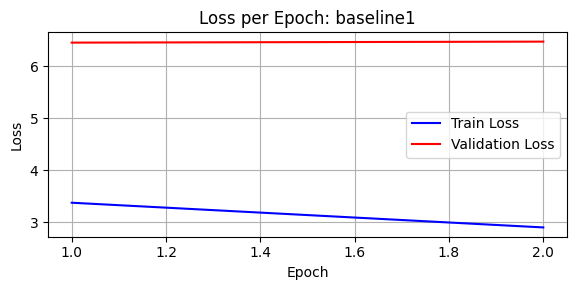

[Batch 0/17] Train Loss: 6.4998
[Batch 1/17] Train Loss: 6.2148
[Batch 2/17] Train Loss: 6.3779
[Batch 3/17] Train Loss: 6.4251
[Batch 4/17] Train Loss: 6.5546
[Batch 5/17] Train Loss: 6.3686
[Batch 6/17] Train Loss: 6.3277
[Batch 7/17] Train Loss: 6.4583
[Batch 8/17] Train Loss: 6.3315
[Batch 9/17] Train Loss: 6.4245
[Batch 10/17] Train Loss: 6.6437
[Batch 11/17] Train Loss: 6.4850
[Batch 12/17] Train Loss: 6.6448
[Batch 13/17] Train Loss: 6.3098
[Batch 14/17] Train Loss: 6.4661
[Batch 15/17] Train Loss: 6.5421
[Batch 16/17] Train Loss: 6.5829


Evaluating Metrics: 100%|██████████| 17/17 [02:00<00:00,  7.06s/it]


Test Loss      : 6.4496
BLEU-4 Score   : 0.1415
METEOR Score   : 0.2901
BERTScore (F1) : 0.8635
=== Evaluating baseline2 ===
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
Training model: baseline2
Epoch 1/2
[Batch 0/2546] Train Loss: 9.1105
[Batch 1/2546] Train Loss: 8.8972
[Batch 2/2546] Train Loss: 8.5180
[Batch 3/2546] Train Loss: 8.0157
[Batch 4/2546] Train Loss: 7.5386
[Batch 5/2546] Train Loss: 6.9495
[Batch 6/2546] Train Loss: 6.4572
[Batch 7/2546] Train Loss: 5.8173
[Batch 8/2546] Train Loss: 5.3788
[Batch 9/2546] Train Loss: 5.1008
[Batch 10/2546] Train Loss: 4.8840
[Batch 11/2546] Train Loss: 5.0117
[Batch 12/2546] Train Loss: 4.9361
[Batch 13/2546] Train Loss: 4.9752
[Batch 14/2546] Train Loss: 4.9353
[Batch 15/2546] Train Loss: 5.0505
[Batch 16/2546] Train Loss: 4.7297
[Batch 17/2546] Train Loss: 4.9119
[Batch 18/2546] Train Loss: 4.6872
[Batch 19/2546] Train Loss: 4.7520
[Batch 20/2546] Train Loss: 4.6650
[Batch 21/2546] Train Loss: 4.7670
[Batch 22/2546] T

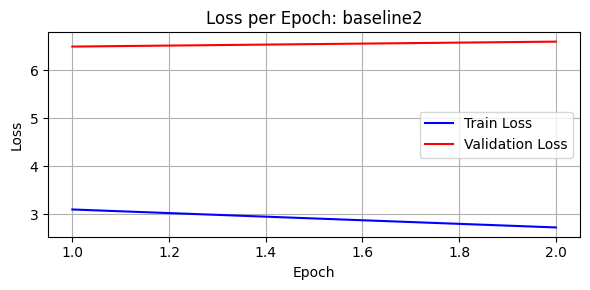

[Batch 0/17] Train Loss: 6.4951
[Batch 1/17] Train Loss: 6.3178
[Batch 2/17] Train Loss: 6.4051
[Batch 3/17] Train Loss: 6.5484
[Batch 4/17] Train Loss: 6.3809
[Batch 5/17] Train Loss: 6.3554
[Batch 6/17] Train Loss: 6.4904
[Batch 7/17] Train Loss: 6.5591
[Batch 8/17] Train Loss: 6.3213
[Batch 9/17] Train Loss: 6.4242
[Batch 10/17] Train Loss: 6.6364
[Batch 11/17] Train Loss: 6.4700
[Batch 12/17] Train Loss: 6.5544
[Batch 13/17] Train Loss: 6.3098
[Batch 14/17] Train Loss: 6.5661
[Batch 15/17] Train Loss: 6.6803
[Batch 16/17] Train Loss: 6.6689


Evaluating Metrics: 100%|██████████| 17/17 [02:02<00:00,  7.20s/it]


Test Loss      : 6.4802
BLEU-4 Score   : 0.1351
METEOR Score   : 0.2663
BERTScore (F1) : 0.8633
=== Evaluating mild_extension1 ===
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
Training model: mild_extension1
Epoch 1/2
[Batch 0/2546] Train Loss: 9.0644
[Batch 1/2546] Train Loss: 8.9018
[Batch 2/2546] Train Loss: 8.2679
[Batch 3/2546] Train Loss: 7.1540
[Batch 4/2546] Train Loss: 6.5056
[Batch 5/2546] Train Loss: 6.1799
[Batch 6/2546] Train Loss: 6.1957
[Batch 7/2546] Train Loss: 6.2359
[Batch 8/2546] Train Loss: 6.2421
[Batch 9/2546] Train Loss: 6.2068
[Batch 10/2546] Train Loss: 6.0573
[Batch 11/2546] Train Loss: 6.0258
[Batch 12/2546] Train Loss: 6.2632
[Batch 13/2546] Train Loss: 6.1085
[Batch 14/2546] Train Loss: 6.2025
[Batch 15/2546] Train Loss: 6.1563
[Batch 16/2546] Train Loss: 6.0826
[Batch 17/2546] Train Loss: 6.1928
[Batch 18/2546] Train Loss: 6.0010
[Batch 19/2546] Train Loss: 6.0296
[Batch 20/2546] Train Loss: 6.0524
[Batch 21/2546] Train Loss: 6.0292
[Batc

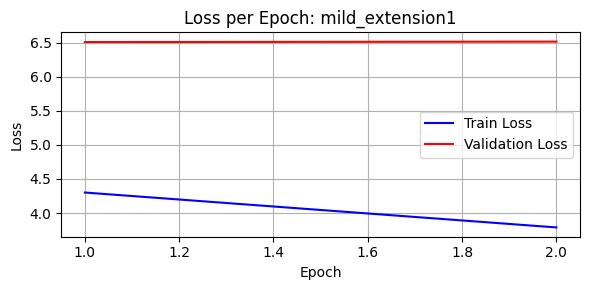

[Batch 0/17] Train Loss: 6.3192
[Batch 1/17] Train Loss: 6.3385
[Batch 2/17] Train Loss: 6.4787
[Batch 3/17] Train Loss: 6.6085
[Batch 4/17] Train Loss: 6.4716
[Batch 5/17] Train Loss: 6.3651
[Batch 6/17] Train Loss: 6.4202
[Batch 7/17] Train Loss: 6.5772
[Batch 8/17] Train Loss: 6.2452
[Batch 9/17] Train Loss: 6.3025
[Batch 10/17] Train Loss: 6.5886
[Batch 11/17] Train Loss: 6.5430
[Batch 12/17] Train Loss: 6.4036
[Batch 13/17] Train Loss: 6.3450
[Batch 14/17] Train Loss: 6.5421
[Batch 15/17] Train Loss: 6.6848
[Batch 16/17] Train Loss: 6.6654


Evaluating Metrics: 100%|██████████| 17/17 [01:25<00:00,  5.03s/it]


Test Loss      : 6.4634
BLEU-4 Score   : 0.0350
METEOR Score   : 0.1713
BERTScore (F1) : 0.8322
=== Evaluating mild_extension2 ===
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
🔎 Loading GloVe vectors...
✅ GloVe embedding matrix created.
Training model: mild_extension2
Epoch 1/2
[Batch 0/2546] Train Loss: 9.0585
[Batch 1/2546] Train Loss: 8.9908
[Batch 2/2546] Train Loss: 8.8305
[Batch 3/2546] Train Loss: 8.3346
[Batch 4/2546] Train Loss: 7.7179
[Batch 5/2546] Train Loss: 6.9405
[Batch 6/2546] Train Loss: 6.5364
[Batch 7/2546] Train Loss: 6.2744
[Batch 8/2546] Train Loss: 6.1365
[Batch 9/2546] Train Loss: 6.0084
[Batch 10/2546] Train Loss: 6.1254
[Batch 11/2546] Train Loss: 6.1244
[Batch 12/2546] Train Loss: 6.1025
[Batch 13/2546] Train Loss: 6.1074
[Batch 14/2546] Train Loss: 6.2527
[Batch 15/2546] Train Loss: 6.1668
[Batch 16/2546] Train Loss: 6.1543
[Batch 17/2546] Train Loss: 6.0062
[Batch 18/2546] Train Loss: 5.9623
[Batch 19/2546] Train Loss: 6.0330
[Batch 20/2546

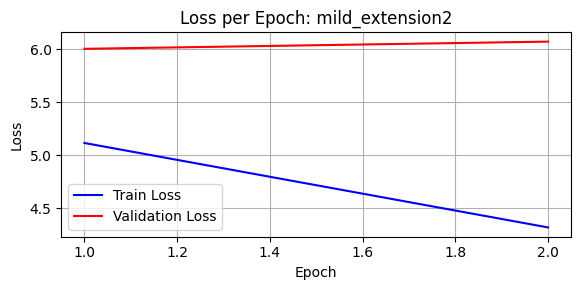

[Batch 0/17] Train Loss: 5.9353
[Batch 1/17] Train Loss: 5.8603
[Batch 2/17] Train Loss: 5.9212
[Batch 3/17] Train Loss: 6.0595
[Batch 4/17] Train Loss: 6.0267
[Batch 5/17] Train Loss: 5.9760
[Batch 6/17] Train Loss: 5.9587
[Batch 7/17] Train Loss: 6.0506
[Batch 8/17] Train Loss: 5.8168
[Batch 9/17] Train Loss: 5.9444
[Batch 10/17] Train Loss: 6.0298
[Batch 11/17] Train Loss: 6.0218
[Batch 12/17] Train Loss: 6.0644
[Batch 13/17] Train Loss: 5.8479
[Batch 14/17] Train Loss: 6.1342
[Batch 15/17] Train Loss: 6.0893
[Batch 16/17] Train Loss: 6.0717


Evaluating Metrics: 100%|██████████| 17/17 [01:23<00:00,  4.91s/it]


Test Loss      : 5.9882
BLEU-4 Score   : 0.0203
METEOR Score   : 0.1301
BERTScore (F1) : 0.8221


In [55]:
for model_type, config in experiment_configs.items():
    print(f"=== Evaluating {model_type} ===")
    model, encoder, decoder, _, save_model_path, save_history_path, test_loader, recipe_vocab = main(
        model_type, config, train_df, dev_df, test_df
    )
    criterion = nn.CrossEntropyLoss(ignore_index=recipe_vocab['<pad>'])
    evaluate_and_report(model_type, config, encoder, decoder, save_model_path, save_history_path,
                        test_loader, criterion, recipe_vocab)


# Plot for all model

In [56]:
# # 여러 모델들의 히스토리를 불러온 후
# baseline1_history = torch.load("results/baseline1_history.pt")["loss_history"]
# baseline2_history = torch.load("results/baseline2_history.pt")["loss_history"]
# mild1_history = torch.load("results/mild_extension1_history.pt")["loss_history"]

# plot_loss_iter(
#     baseline1=baseline1_history,
#     baseline2=baseline2_history,
#     mild_extension1=mild1_history
# )


# Generator

In [57]:
def generate_recipes(ingredient_list, ingredient_vocab, recipe_vocab, max_len=30, is_raw_string=False, **models):

    # Tokenizer 적용 여부
    if is_raw_string:
        tokens = tokenizer_ingredient(str(ingredient_list))
    else:
        tokens = ingredient_list

    # index로 변환
    tokens_ids = [ ingredient_vocab[token] if token in ingredient_vocab else ingredient_vocab['<unk>'] for token in tokens]
    src_tensor = torch.tensor(tokens_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)

    print("Ingredient :",', '.join(tokens))
    for name, model in models.items():
        model.eval()
        with torch.no_grad():
            generated = model(src_tensor, target=None, teacher_forcing_ratio=0.0, max_len=max_len)
            pred_ids = generated[0].tolist()

            # <eos> 기준으로 자르기
            if recipe_vocab['<eos>'] in pred_ids:
                pred_ids = pred_ids[:pred_ids.index(recipe_vocab['<eos>'])]

            pred_tokens = [recipe_vocab.get_itos()[idx] for idx in pred_ids]
            print(f"{name}: {' '.join(pred_tokens[:30])}")
    print("-" * 100)

    

In [58]:
models = {
    "baseline1": load_baseline1,
    # "baseline2": load_baseline2
}

# # Sample 1: 전처리된 리스트
sample1_raw = "sugar, lemon juice,  water,  orange juice, strawberries, icecream"
sample1 = sample1_raw.split(", ")
generate_recipes(sample1, ingredient_vocab, recipe_vocab, is_raw_string=False, **models)

# Sample2 : 
sample2_raw ="8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c  lemon juice, 48 oz canned cherries, 8 inch graham cracker,  pie crusts"
sample2 = sample2_raw.split(", ")
generate_recipes(sample2, ingredient_vocab, recipe_vocab, is_raw_string=True, **models)

NameError: name 'load_baseline1' is not defined